In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

epochs = 10
batch_size = 16
lr = 1e-3
lr_decay = 1e-7

train_dir = "carla-dataset/train/images"
annotation_dir = "carla-dataset/train/annotations/"

In [2]:
class CarlaDataset(Dataset):
    
    def __init__(self, root_dir, annotation_dir, resize=(128,128), transform=None):
        
        """
        @param:
            root_dir (str): path of the input images from the CARLA simulator
            annotation_dir (str): path of the input annotation images
            resize(tup): pass in a tuple of the new image + annotation input sizes   
            transform(torvision.transforms): input a torchvision.transforms attribute to the class for further data preprocessing.
            
        """
        
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.resize = resize
        self.dataset = []
        
        for (img_name,annotation_name) in zip(os.listdir(self.root_dir),os.listdir(self.annotation_dir)):
            self.dataset.append([os.path.join(root_dir,img_name),os.path.join(annotation_dir,annotation_name)])

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, annotation = self.dataset[idx]
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,self.resize)
        img = img/255.0
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)
        
        annotation = cv2.imread(annotation,0)
        annotation = cv2.resize(annotation,self.resize)
        annotation = annotation.astype(np.float32)
        annotation = np.expand_dims(annotation, axis=0)
        annotation[annotation!=0] = 1 #classify both lanes as only 1 class

        img = torch.from_numpy(img)
        annotation = torch.from_numpy(annotation) 
        
        return img, annotation

In [3]:
carla_dataset = CarlaDataset(train_dir,annotation_dir,resize=(128,128))
data_loader = DataLoader(carla_dataset, batch_size=batch_size, shuffle=True)
img, annot = next(iter(data_loader))
print(f"dataset length: {len(carla_dataset)} \nimg shape: {img.shape}, annotations shape: {annot.shape}")

dataset length: 2922 
img shape: torch.Size([16, 1, 128, 128]), annotations shape: torch.Size([16, 1, 128, 128])


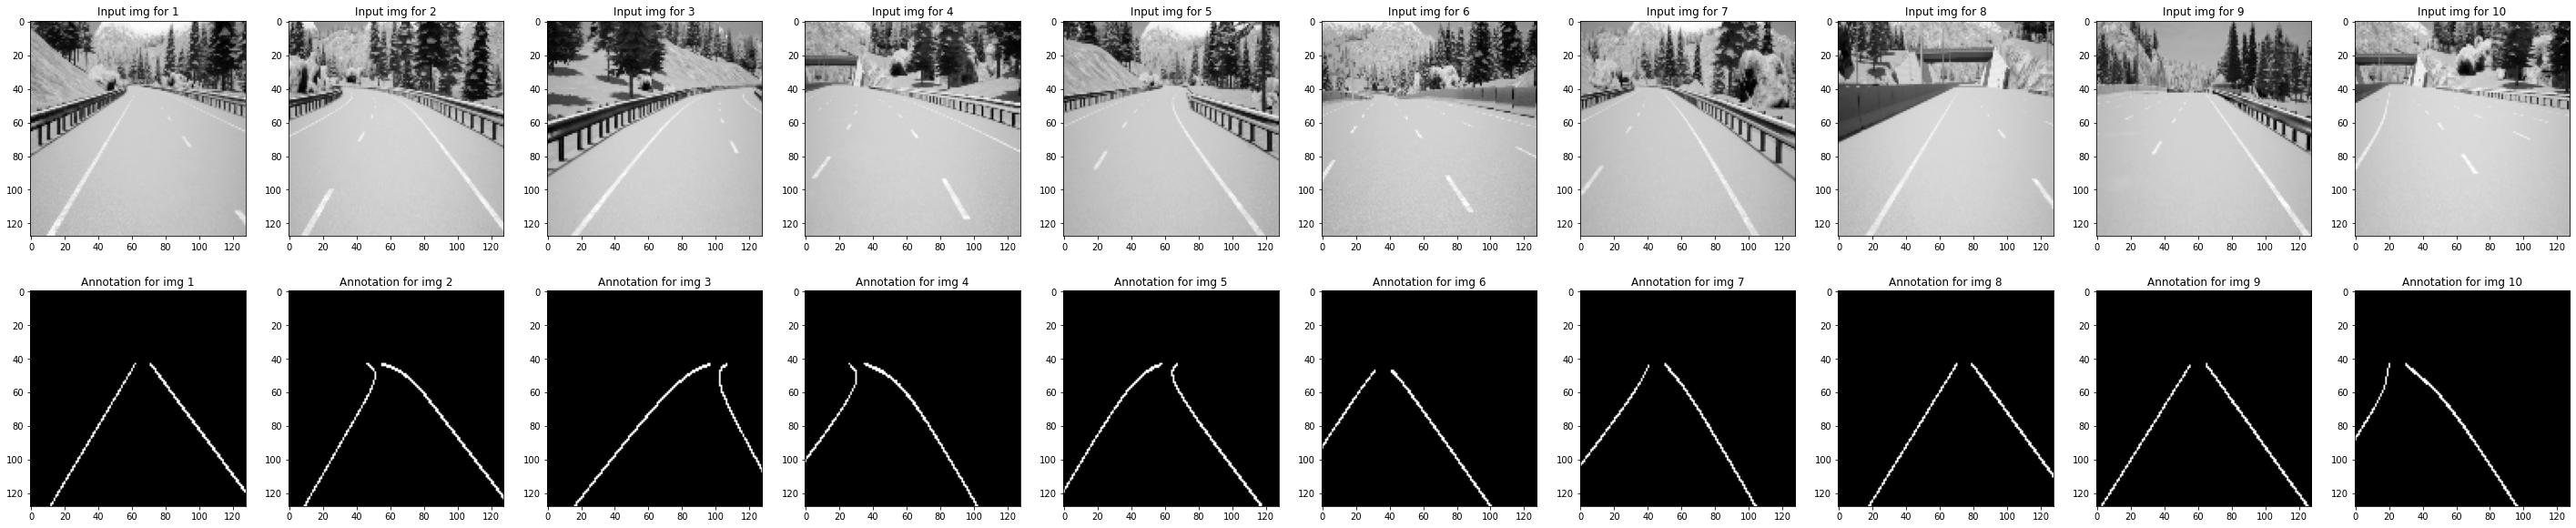

In [4]:
plt.figure(figsize=(50, 10))
for j in range(10):
    if j >= 10: break
    image = np.squeeze(img[j].detach().cpu().numpy())
    plt.subplot(2, 10, j+1)
    plt.title(f"Input img for {j+1}")
    plt.imshow(image,cmap="gray")

for k in range(10):
    if k >= 10: break
    annotation = np.squeeze(annot[k].detach().cpu().numpy())
    plt.subplot(2, 10, 10+k+1)
    plt.title(f"Annotation for img {k+1}")
    plt.imshow(annotation,cmap="gray")

In [5]:
class Residual_Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride, affine, track_running_stats):
        
        super(Residual_Block, self).__init__()
        
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1)
        self.skip_conv = nn.Conv2d(in_channels, out_channels, 1, padding=0, stride=stride)
        
        self.in_1 = nn.InstanceNorm2d(in_channels, affine=affine, track_running_stats=track_running_stats)
        self.in_2 = nn.InstanceNorm2d(out_channels, affine=affine, track_running_stats=track_running_stats)

    def forward(self, x):
        
        res_block = self.in_1(self.relu(x))
        res_block = self.conv1(res_block)
        res_block = self.in_2(self.relu(res_block))
        res_block = self.conv2(res_block)
        s = self.skip_conv(x)
        skip = res_block + s
        return skip

class Decoder_Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, affine, track_running_stats):
        
        super(Decoder_Block, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.res_block = Residual_Block(in_channels + out_channels, out_channels, stride=1, affine=affine, track_running_stats=track_running_stats)

    def forward(self, x, skip):
        
        dec_block = self.upsample(x)
        dec_block = torch.cat([dec_block, skip], axis=1)
        dec_block = self.res_block(dec_block)
        return dec_block

In [6]:
class ResUNet_Model(nn.Module):
    
    def __init__(self, in_channels, out_channels, affine, track_running_stats):
        
        """
        Implementation of, "ResUNet-a: a deep learning framework for semantic segmentation of remotely sensed data" (Diakogiannis et al., 2019)
        https://arxiv.org/pdf/1904.00592.pdf
        
        @param:
            in_channels (int): specify the number of input channels for the image
            out_channels (int): specify the number of output channels to be released from the U-Net model
            affine (bool): specify if the U-Net model should have learnable affine parameters
            track_running_stats (bool): specify if the U-Net model should be tracking the mean and variance
        
        @note:
            The paper, "Normalization in Training U-Net for 2D Biomedical Semantic Segmentation" (Zhou et al., 2018)  states that the
            use of Instance Normalization can create higher accuracy than other state-of-the-art methods such as Batch Normalization and
            Layer Normalization to help combat the epxloding gradients problem in U-Net network systems.

            I choose to use Instance Normalization (IN) after every time ReLU is applied on top of a convolution. This will now allow for
            proper normalization to occur throughout training. I also choose to set the IN to have learnable affine parameters and allow
            it to track the running mean and variance instead of choosing to use batch statistics for training and evaluation modes.
            
        @note:
            According to the Deep Learning Book (Goodfellow et al., 2016), batch normalization should be used after an activation is applied.
            This is the modification that I make to the original Resunet implementation to ensure that I can get the highest possible outputs
            for the segmentation task.
        """

        super(ResUNet_Model, self).__init__()
        
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, 64, kernel_size=1, padding=0)
        self.conv4 = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)
        
        self.res_block_1 = Residual_Block(64, 128, stride=2,affine=affine,track_running_stats=track_running_stats)
        self.res_block_2 = Residual_Block(128, 256, stride=2,affine=affine,track_running_stats=track_running_stats)
        self.res_block_3 = Residual_Block(256, 512, stride=2,affine=affine,track_running_stats=track_running_stats)

        self.dec_block_1 = Decoder_Block(512, 256,affine=affine,track_running_stats=track_running_stats)
        self.dec_block_2 = Decoder_Block(256, 128,affine=affine,track_running_stats=track_running_stats)
        self.dec_block_3 = Decoder_Block(128, 64,affine=affine,track_running_stats=track_running_stats)

        self.in_1 = nn.InstanceNorm2d(64,affine=affine,track_running_stats=track_running_stats)
        

    def forward(self, x):
        
        enc_1 = self.relu(self.in_1(self.conv1(x)))
        enc_1 = self.conv2(enc_1)
        s = self.conv3(x)
        skip_1 = x + s

        skip_2 = self.res_block_1(skip_1)
        skip_3 = self.res_block_2(skip_2)
        
        bridge = self.res_block_3(skip_3)

        dec_block_1 = self.dec_block_1(bridge, skip_3)
        dec_block_2 = self.dec_block_2(dec_block_1, skip_2)
        dec_block_3 = self.dec_block_3(dec_block_2, skip_1)

        output = self.conv4(dec_block_3)
        output = torch.sigmoid(output)

        return output

In [7]:
model = ResUNet_Model(in_channels=1,out_channels=1,affine=True,track_running_stats=True).to(device)
# summary(model,(1,128,128))
summary(model,(1,128,128),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
    InstanceNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
            Conv2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
    InstanceNorm2d-7         [-1, 64, 128, 128]             128
            Conv2d-8          [-1, 128, 64, 64]          73,856
              ReLU-9          [-1, 128, 64, 64]               0
   InstanceNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 128, 64, 64]         147,584
           Conv2d-12          [-1, 128, 64, 64]           8,320
   Residual_Block-13          [-1, 128, 64, 64]               0
             ReLU-14          [-1, 128,

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
outputs = []

criterion = IoULoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

steps_per_epoch = len(carla_dataset) // batch_size


for epoch in range(epochs):
    print('-'*20)
    for i, (img, annotation) in enumerate(data_loader):
        
        img = img.to(device)
        annotation = annotation.to(device)
        
        output = model(img)
        loss = criterion(output, annotation)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (int(i+1))%(steps_per_epoch//5) == 0:
            print(f"epoch {epoch+1}/{epochs}, step {i+1}/{steps_per_epoch}, IoU score = {1-loss.item():.4f}")
            
    outputs.append((img, annotation, output))

--------------------
epoch 1/10, step 36/182, IoU score = 0.3039
epoch 1/10, step 72/182, IoU score = 0.4903
epoch 1/10, step 108/182, IoU score = 0.5183
epoch 1/10, step 144/182, IoU score = 0.5778
epoch 1/10, step 180/182, IoU score = 0.5956
--------------------
epoch 2/10, step 36/182, IoU score = 0.6373
epoch 2/10, step 72/182, IoU score = 0.6142
epoch 2/10, step 108/182, IoU score = 0.7019
epoch 2/10, step 144/182, IoU score = 0.6503
epoch 2/10, step 180/182, IoU score = 0.6756
--------------------


In [ ]:
plt.figure(figsize=(15, 50))
for i in range(epochs):   
    image = np.squeeze(outputs[i][0][0].detach().cpu().numpy())
    ground_truth = np.squeeze(outputs[i][1][0].detach().cpu().numpy())
    prediction = np.squeeze(outputs[i][2][0].detach().cpu().numpy())
    i += 1
    plt.subplot(epochs, 3, 3*i-2)
    plt.title(f"Image for epoch {i}")
    plt.imshow(image,cmap="gray")
    plt.subplot(epochs, 3, 3*i-1)
    plt.title(f"Ground truth for epoch {i}")
    plt.imshow(ground_truth,cmap="gray")
    plt.subplot(epochs, 3, 3*i)
    plt.title(f"Prediction for epoch {i}")
    plt.imshow(prediction,cmap="gray")
plt.show()

In [ ]:
PATH = "resunet_model.pth"
torch.save(model.state_dict(), PATH) 
print("Model saved")